# <div align = "center"> Определение параметров модели Брукса-Кори по экспериментальным данным.

In [ ]:
from google.colab import drive
drive.mount('/MD')

## Блок импорта необходимых библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

In [ ]:
from scipy import interpolate
from scipy.misc import derivative

In [ ]:
from scipy.optimize import minimize

## Загрузим данные

In [ ]:
init_data = pd.read_excel('/MD/MyDrive/task_data.xlsx')
init_data

## Проанализируем данные. Для наглядности рассмотрим первые 60 строчек таблицы.

In [ ]:
init_data.head(60)

## Ограничимся целевыми атрибутами: Скважина; Лабораторный номер образца; Водонасыщенность; Капиллярное давление

In [ ]:
init_data.columns

Index(['Скважина', 'Стратиграфическая единица', 'Лабораторный номер образца',
       'Метод исследования', 'Интервал отбора, м', 'Unnamed: 5',
       'Место взятия, м', 'Литологическое описание', 'Пористость, % ',
       'Проницаемость, мД', 'Водонасыщенность, %',
       'Капиллярное давление, МПа'],
      dtype='object')

In [ ]:
prep1_data = init_data[['Скважина', 'Лабораторный номер образца', 'Водонасыщенность, %', 'Капиллярное давление, МПа']]

In [ ]:
prep1_data.columns

Index(['Скважина', 'Лабораторный номер образца', 'Водонасыщенность, %',
       'Капиллярное давление, МПа'],
      dtype='object')

## Заполним NaN-значения в атрибуте "Лабораторный номер образца", для того, чтобы кривые капилярного давления характеризовались уникальным ключом.

In [ ]:
prep1_data = prep1_data[pd.notna(prep1_data['Скважина']) == True]

In [ ]:
prep2_data = prep1_data.copy()
prep2_data.reset_index(inplace = True)

In [ ]:
for i in range(len(prep2_data) - 1):
  if prep2_data['Скважина'][i] == prep2_data['Скважина'][i + 1] and pd.notna(prep2_data['Лабораторный номер образца'][i + 1]) is False:
    prep2_data['Лабораторный номер образца'][i + 1] = prep2_data['Лабораторный номер образца'][i]
  else:
    continue

In [ ]:
prep2_data.drop(['index'], axis=1, inplace = True)

## Проверим корректность заполнения

In [ ]:
prep2_data.head(13) # видим, что всё корректно

In [ ]:
prep2_data[130:150] # видим, что всё корректно

## Далее займёмся непосредственным подбором параметров модели. Сделаем это на примере первого образца 33874-07, потом подход распространим на остальные образцы

In [ ]:
fst_sample = prep2_data[prep2_data['Лабораторный номер образца'] == '33874-07']
fst_sample

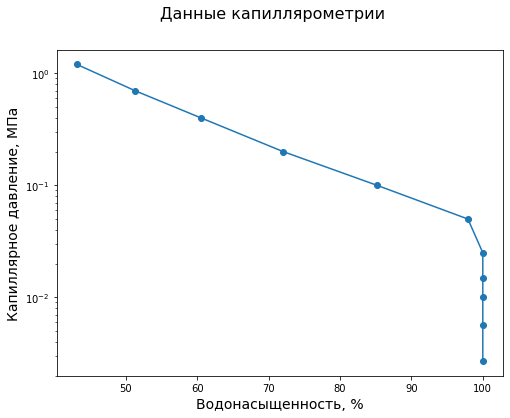

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))

fig.suptitle('Данные капиллярометрии', fontsize = 16)

ax.set_xlabel('Водонасыщенность, %', fontsize = 14)
ax.set_ylabel('Капиллярное давление, МПа', fontsize = 14)
ax.semilogy(fst_sample['Водонасыщенность, %'], fst_sample['Капиллярное давление, МПа'], 'o-')
plt.show()

## Модель Брукса-Кори представляет собой уравнение вида:<p>
$$ S_w = S_{wi} + (1 + S_{wi})( \frac{P_d}{P_C} )^{(\frac1n)}\ , где $$
<p>
$$ S_w - замеренная водонасыщенность, д. ед. $$
$$ S_{wi} - остаточная водонасыщенность, д. ед. $$
$$ P_d - входное капиллярное давление, МПа $$
$$ P_С - замеренное капиллярное давление, P_C > P_d, МПа $$

### Наша задача - оценить параметры  Swi, Pd и n.<p>
### Swi, Pd найдём из гарфика, n - из минимизации целевой функции (функционал невязки).

In [ ]:
fst_sample_Swi = fst_sample['Водонасыщенность, %'].iloc[-1]

## Pd найдём из условия точки излома. Оно определяется неравенством правых и левых пределов производной функции в точке.
## Но добиться строгого равенства на дискретном наборе данных не получится, иными словами из исходного условия все точки становятся изломными
## Мы огрубим это условие, сделав его условием максимума модуля второй производной (ускорения роста функции) при условии, что аргумент Sw данного максимума не меньше 90%

In [ ]:
p_interp_fstsm = np.linspace(np.log10(fst_sample['Капиллярное давление, МПа'].values.min()), np.log10(fst_sample['Капиллярное давление, МПа'].values.max()), 20)

In [ ]:
sw_interp_fstsm = interpolate.PchipInterpolator(np.log10(fst_sample['Капиллярное давление, МПа'].values),  fst_sample['Водонасыщенность, %'].values)

In [ ]:
def snd_deriv (p, Sw ):
  return (np.diff ( np.diff(Sw(p) ) / np.diff(p) )) / np.diff ( p  ) [:-1]

In [ ]:
abs_snd_deriv = np.abs(snd_deriv(p_interp_fstsm, sw_interp_fstsm))

for i in range(2):
  condition = np.where(abs_snd_deriv == abs_snd_deriv.max())[0][0]
  ind_break = condition + 1
  comp_val = sw_interp_fstsm(p_interp_fstsm)[ind_break]

  if comp_val < 90:
    np.delete(abs_snd_deriv, condition)
  else:
    break

In [ ]:
Abs_delta_regular = np.abs(fst_sample['Водонасыщенность, %'] - comp_val)
Pd_ind = np.where(Abs_delta_regular == Abs_delta_regular.min())[0][0]
fst_sample_Pd = fst_sample['Капиллярное давление, МПа'][Pd_ind]

In [ ]:
print('Pd = {0}, Swi = {1}'.format(fst_sample_Pd, fst_sample_Swi))

Pd = 0.05, Swi = 43.16294519283995


## Далее у нас два пути: минимизация одним из методов-вариаций градиентного спуска: <p>
$$ 
\operatorname*{arg\, min}_n 
 \sum_{k = 1}^{M} (S_{w_k} - S_{wi} - (1 + S_{wi})( \frac{P_d}{P_{C_k}} )^{(\frac1n)}\ )^2 $$
## Или же решение СЛАУ, получаемого логарифмированием исходного выражения:
$$ lg(S_w - S_{wi}) - lg(1 + S_{wi}) = {\frac1n}(lgP_d - lgP_C) $$
## Примечание: с путём 2 вышла проблема, поэтому он был оставлен на дополнительное рассмотрение позднее

### Путь первый

Отберём интервалы, для которых будем производить подбор модели. Оставшиеся значения будем аппроксимировать 100% водонасыщенностью

In [ ]:
approx_Sw = fst_sample['Водонасыщенность, %'][fst_sample['Водонасыщенность, %'] < fst_sample['Водонасыщенность, %'][Pd_ind]].values / 100

In [ ]:
approx_Pc = fst_sample['Капиллярное давление, МПа'][fst_sample['Капиллярное давление, МПа'] > fst_sample['Капиллярное давление, МПа'][Pd_ind]].values

In [ ]:
approx_Pc

array([0.1, 0.2, 0.4, 0.7, 1.2])

In [ ]:
approx_Sw

array([0.85181768, 0.72042812, 0.60527773, 0.51282524, 0.43162945])

Определим целевую функцию для минимизации

In [ ]:
def target_func(n):
  return np.sum(np.power(approx_Sw - fst_sample_Swi / 100 - (1 + fst_sample_Swi / 100) * np.power( (fst_sample_Pd / approx_Pc), 1/n ), 2))

Найдём точку минимума

In [ ]:
%%time
minimized_target = minimize(target_func, 0.1, method = 'COBYLA')
minimized_target

CPU times: user 1.89 ms, sys: 0 ns, total: 1.89 ms
Wall time: 1.89 ms


In [ ]:
minimized_target

     fun: 0.033361389891044195
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 24
  status: 1
 success: True
       x: array(0.70624531)

In [ ]:
n_calc = minimized_target['x']

Объединим интервал аппроксимации с интервалом, содержащим 100% водонасыщенность

In [ ]:
Sw_calc = []
Hundreds = list(np.ones(len(fst_sample['Капиллярное давление, МПа'][fst_sample['Капиллярное давление, МПа'] <= fst_sample['Капиллярное давление, МПа'][Pd_ind]].values)))
Sw_calc.append( 
    list(fst_sample_Swi/100 + (1 + fst_sample_Swi/100) * np.power( fst_sample_Pd / approx_Pc, 1/n_calc))
    )
Sw_calc.insert(0, Hundreds)
Sw_calc = np.array(Sw_calc[0] + Sw_calc[1])

In [ ]:
Sw_calc

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.96815528, 0.63270101, 0.50698421, 0.46574746,
       0.44753455])

График

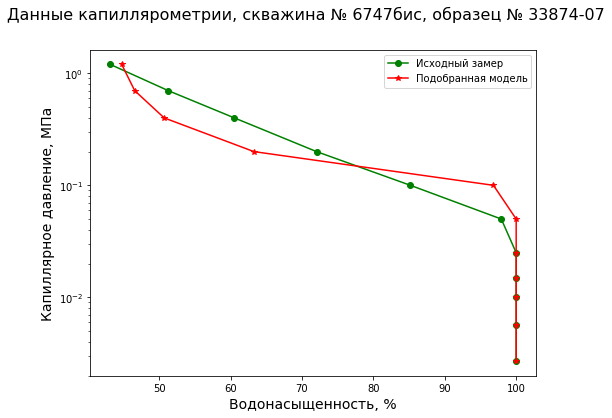

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))

fig.suptitle('Данные капиллярометрии, скважина № {0}, образец № {1}'.format(fst_sample['Скважина'].unique()[0], fst_sample['Лабораторный номер образца'].unique()[0]), fontsize = 16)

ax.set_xlabel('Водонасыщенность, %', fontsize = 14)
ax.set_ylabel('Капиллярное давление, МПа', fontsize = 14)
ax.semilogy(fst_sample['Водонасыщенность, %'], fst_sample['Капиллярное давление, МПа'], 'go-', label = 'Исходный замер')
ax.semilogy(Sw_calc*100, fst_sample['Капиллярное давление, МПа'], 'r*-', label = 'Подобранная модель')
ax.legend()
plt.show()

## Теперь распространим решение на остальные кривые

In [ ]:
Swi = {}
Pd = {}
n = {} # хэш-таблицы записи параметров
Sw_estim = {} # хэш таблица записи рассчитанного Sw

In [ ]:
filt_Sw = 'Водонасыщенность, %'
filt_Pc = 'Капиллярное давление, МПа' # глобальные фильтры

### Определение параметров Swi, Pd и n

In [ ]:
for sample in prep2_data['Лабораторный номер образца'].unique():
  
  filt_sample = prep2_data['Лабораторный номер образца'] == sample # фильтр по скважине

  ##### ОПРЕДЕЛЕНИЕ ПАРАМЕТРА Swi #####

  Swi[sample] = prep2_data[ filt_sample ][filt_Sw].values[-1] # определение Swi
  

  ##### ОПРЕДЕЛЕНИЕ ПАРАМЕТРА Pd #####

  p_interp = np.linspace(
      np.log10(prep2_data[ filt_sample ][ filt_Pc ].values.min()),
      np.log10(prep2_data[ filt_sample ][ filt_Pc ].values.max()), 20
      ) # регулярная сетка давлений
  sw_interp = interpolate.PchipInterpolator(
      np.log10(prep2_data[ filt_sample ][ filt_Pc ].values), 
      prep2_data[ filt_sample ][ filt_Sw ].values
      ) # интерполяция значений насыщенности

  abs_snd_der = np.abs(snd_deriv(p_interp, sw_interp)) # абсолютные значения второй производной интерполированной функции

  for i in range(len(abs_snd_der)):
    condit = np.where(abs_snd_der == abs_snd_der.max())[0][0]
    ind_brk = condit + 1
    Sw_in_Pd_val = sw_interp(p_interp)[ind_brk] # выбор насыщенности в точке Pd

    if Sw_in_Pd_val < 90:
      abs_snd_der = np.delete(abs_snd_der, condit) # если меньше 90, то отбрасываем (нефизично)
    else:
      break
  
  Abs_delta_reg = np.abs(prep2_data[ filt_sample ][ filt_Sw ] - Sw_in_Pd_val)
  # массив абсолютных разниц между истинными значениями и полученным интерполированным
  
  i = 0 
  memorizer = 0
  iterator = Abs_delta_reg.values
  while i < len(iterator):
    if iterator[i] == iterator[i + 1]:
      iterator = np.delete(iterator, i)
      memorizer += 1
      continue # пропускаем участки с равными значениями насыщенности, чтобы произошло корректное присвоение значения капиллярного давления

    Pd_index = np.where(iterator == iterator.min())[0][0] + memorizer # индекс выбираем из условия минимальной разницы по модулю между истинными и полученным из интерполяции значением
    
    if prep2_data[ filt_sample ][ filt_Sw ].values[Pd_index] < 90:
      iterator = np.delete(iterator, Pd_index - memorizer)
      Pd_index = np.where(iterator == iterator.min())[0][0] + memorizer
      break

    break

  Pd[sample] = prep2_data[ filt_sample ][ filt_Pc ].values[Pd_index] # получаем значение Pd

  if sample == '3658/12':
    Pd_index += 1
    Pd[sample] = prep2_data[ filt_sample ][ filt_Pc ].values[Pd_index] # аномальный образец

  ##### ОПРЕДЕЛЕНИЕ ПАРАМЕТРА n #####

  approx_Sw = prep2_data[ filt_Sw ][ filt_sample ][ prep2_data[ filt_sample ][ filt_Sw ] < prep2_data[ filt_sample ] [ filt_Sw ].values[Pd_index] ].values / 100 # выбор интервала подбора модели по Sw
  approx_Pc = prep2_data[ filt_Pc ][ filt_sample ][ prep2_data[ filt_sample ][ filt_Pc ] > prep2_data[ filt_sample ] [ filt_Pc ].values[Pd_index]].values # выбор интервала подбора модели по Pc

  def target_func(n):
    return np.sum(np.power(approx_Sw - Swi[sample] / 100 - (1 + Swi[sample] / 100) * np.power( (Pd[sample] / approx_Pc), 1 / n ), 2)) # создание целевой функции для подбора n
  
  minimized_target = minimize(target_func, 1)
  n[sample] = minimized_target['x'] # нахождение минимума по n

  Sw_estim[sample] = []
  
  Ones = list(
      np.ones(
          len(
              prep2_data[ filt_sample ][ filt_Pc ] [ prep2_data[ filt_sample ][ filt_Pc ] <= prep2_data[ filt_sample ][ filt_Pc ].values[Pd_index] ].values
              )
          )
      ) # создание интервала единиц (в области, где аппроксимация не проводилась)
  
  Sw_estim[sample].append( 
      list(
          Swi[sample] / 100 + (1 + Swi[sample] / 100) * np.power( (Pd[sample] / approx_Pc), 1/n[sample])
          )
      ) # добавление рассчитанных значений Sw
  
  Sw_estim[sample].insert(0, Ones)
  Sw_estim[sample] = np.array(Sw_estim[sample][0] + Sw_estim[sample][1]) # объединение расчётного интервала и интервала с единицами

Графики

Введите номер скважины: 8437
Введите номер образца: 2601/13


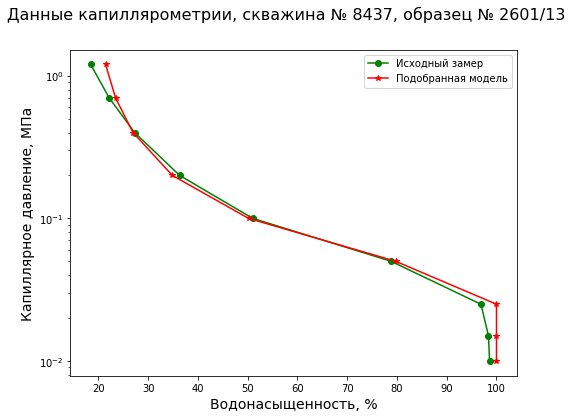

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))

key_correction = False

while key_correction is False:
  well_name = input('Введите номер скважины: ')
  sample_number = input('Введите номер образца: ')

  if well_name in [str(el) for el in prep2_data['Скважина'].unique()] and sample_number in prep2_data['Лабораторный номер образца'].unique():
    if str(prep2_data['Скважина'][prep2_data['Лабораторный номер образца'] == sample_number].unique()[0]) == well_name:
      key_correction = True
    else:
      print('Такого сочетания "образец-скважина" не существует!')
      key_correction = False
  else:
    print('Такой скважины или образца не существует!')
    key_correction = False

fig.suptitle('Данные капиллярометрии, скважина № {0}, образец № {1}'.format(well_name, sample_number), fontsize = 16)

ax.set_xlabel('Водонасыщенность, %', fontsize = 14)
ax.set_ylabel('Капиллярное давление, МПа', fontsize = 14)

ax.semilogy(prep2_data[prep2_data['Лабораторный номер образца'].astype('string') == sample_number]['Водонасыщенность, %'], prep2_data[prep2_data['Лабораторный номер образца'].astype('string') == sample_number]['Капиллярное давление, МПа'], 'go-', label = 'Исходный замер')
ax.semilogy(Sw_estim[sample_number]*100, prep2_data[prep2_data['Лабораторный номер образца'].astype('string') == sample_number]['Капиллярное давление, МПа'], 'r*-', label = 'Подобранная модель')

ax.legend()

plt.show()